In [86]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='white', font='CMU Serif')

In [2]:
class Inputs():
    def __init__(self, nCS=1, nCTX=2, dim_CS=3, dim_CTX=2, seed=0):
        self.rng = np.random.RandomState(seed=seed)
        self.sampler = nengo.dists.UniformHypersphere(surface=True)
        self.dim_CS = dim_CS
        self.dim_CTX = dim_CTX
        self.nCS = nCS
        self.nCTX = nCTX
        self.CS = np.zeros((self.dim_CS))
        self.US = 0
        self.CTX = np.zeros((self.dim_CTX))
        self.CSs = self.sampler.sample(nCS, dim_CS, rng=self.rng)
#         self.CTXs = self.sampler.sample(nCTX, dim_CTX, rng=self.rng)
        self.CTXs = np.array([[0,1], [1,0]])
    def get_CS(self, t):
        idx = int(t/2) % self.nCS
        applied = True if t%2>1 else False  # 1s of no input, 1s of CS input
        self.CS = self.CSs[idx] if applied else np.zeros((self.dim_CS))
        return self.CS
    def get_CTX(self, t):
        return self.CTX
    def get_US(self, t):
        idx = int(t/2) % self.nCS
        applied = True if t%2>1 else False # 1s of no input, 1s of US input 
        return self.US if applied else 0

In [3]:
seed = 0
nNeurons = 200
dim_CS = 3
dim_CTX = 2
inputs = Inputs(nCS=1, dim_CS=dim_CS, dim_CTX=dim_CTX, seed=seed)

net = nengo.Network(seed=seed)
net.config[nengo.Connection].synapse = 0.01
net.config[nengo.Probe].synapse = 0.01
intercepts_pos = nengo.dists.Uniform(0, 1)
encoders_pos = nengo.dists.Choice([[1]])
encoders_ctx = nengo.dists.Choice([[1, 0], [0, 1], [-1, 0], [0, -1]])

with net:
    # inputs
    CS = nengo.Node(lambda t, x: inputs.get_CS(t), size_in=2)
    US = nengo.Node(lambda t, x: inputs.get_US(t), size_in=2)
    CTX = nengo.Node(lambda t, x: inputs.get_CTX(t), size_in=2, size_out=2)
    # external ensembles
#     external_CS = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)
    external_CS = nengo.Ensemble(dim_CS*nNeurons, dim_CS)
#     external_US = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)
    external_US = nengo.Ensemble(nNeurons, 1)
    external_CTX = nengo.Ensemble(dim_CTX*nNeurons, dim_CTX, intercepts=intercepts_pos, encoders=encoders_ctx)
    # amygdala ensembles
    BLA = nengo.Ensemble(4*nNeurons, 4, radius=2)  # [CS, US, CTX, combined]
    error_CS = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)
    error_noCS = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)
    # external connections
    nengo.Connection(CS, external_CS, synapse=None)
    nengo.Connection(US, external_US, synapse=None)
    nengo.Connection(CTX, external_CTX, synapse=None)
    # learned connections
    conditioning = nengo.Connection(external_CS, BLA[0], function=lambda x: 0, learning_rule_type=nengo.PES(5e-5))
    aversion = nengo.Connection(external_US, BLA[1])
    # error connections
    nengo.Connection(BLA, error_CS, function=lambda x: x[1]-x[0])  # US - (CS response)
    nengo.Connection(error_CS, conditioning.learning_rule, transform=-1)
    nengo.Connection(BLA, error_noCS, function=lambda x: x[0])  # (CS response)
#     nengo.Connection(external_CS, error_noCS, function=lambda x: np.linalg.norm(x, ord=2))  # any CS present
    nengo.Connection(external_CS, error_noCS, function=lambda x: -np.sum(np.square(x)))  # any CS present
    nengo.Connection(error_noCS, conditioning.learning_rule, transform=2)
    # probes
    pCS = nengo.Probe(CS, synapse=None)
    pUS = nengo.Probe(US, synapse=None)
    pCTX = nengo.Probe(CTX, synapse=None)
    pExternal_CS = nengo.Probe(external_CS)
    pSpikes = nengo.Probe(BLA.neurons)
    pBLA = nengo.Probe(BLA)
    pError_CS = nengo.Probe(error_CS)
    pError_noCS = nengo.Probe(error_noCS)

### Experiment 1: CS-US conditioning

In [4]:
dt = 0.001
nTrials_conditioning = 3

sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    print("baseline")
    inputs.CTX = inputs.CTXs[0]
    sim.run(2)
    print("conditioning")
    inputs.CTX = inputs.CTXs[0]
    inputs.US = 1
    for p in range(nTrials_conditioning):
        sim.run(2)
    print("expression")
    inputs.CTX = inputs.CTXs[0]
    inputs.US = 0
    sim.run(2)

baseline
conditioning
expression


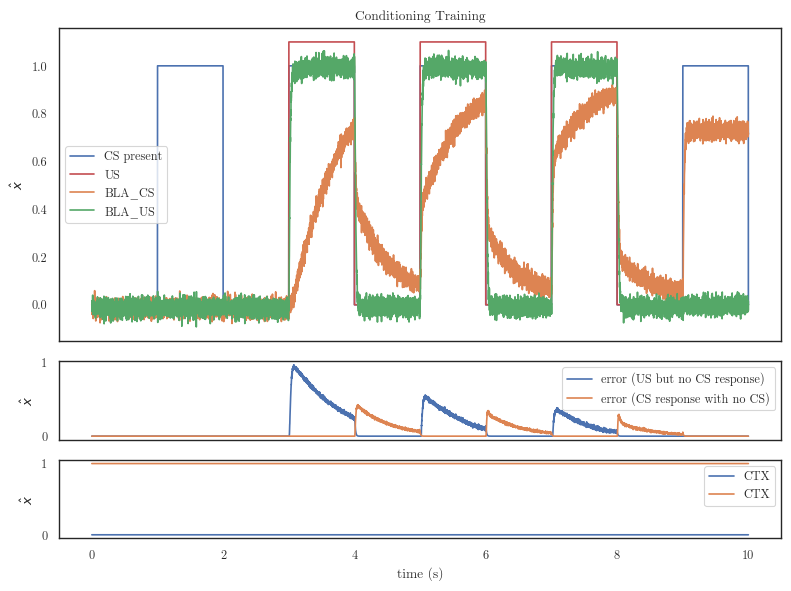

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=((8,6)), gridspec_kw={'height_ratios': [4,1,1]})
# axes[0].plot(sim.trange(), sim.data[pCS], label="CS")
axes[0].plot(sim.trange(), np.linalg.norm(sim.data[pCS], ord=2, axis=1), label="CS present")
axes[0].plot(sim.trange(), 1.1*sim.data[pUS], label="US", c='r')
axes[0].plot(sim.trange(), sim.data[pBLA][:,0], label="BLA_CS")
axes[0].plot(sim.trange(), sim.data[pBLA][:,1], label="BLA_US")
axes[0].legend()
axes[0].set(ylabel=r"$\hat{x}$", title="Conditioning Training")
axes[1].plot(sim.trange(), sim.data[pError_CS], label="error (US but no CS response)")
axes[1].plot(sim.trange(), sim.data[pError_noCS], label="error (CS response with no CS)")
axes[1].legend()
axes[1].set(ylabel=r"$\hat{x}$", yticks=((0,1)))
axes[2].plot(sim.trange(), sim.data[pCTX], label="CTX")
axes[2].set(ylabel=r"$\hat{x}$", xlabel="time (s)", yticks=((0,1)))
axes[2].legend()
plt.tight_layout()

### Experiments 2: CS-CTX-US extinction

In [6]:
with net:
    # error ensembles
    error_CTX = nengo.Ensemble(nNeurons, 1, intercepts=intercepts_pos, encoders=encoders_pos)
    # learned connections
    extinction = nengo.Connection(external_CTX, BLA[2], function=lambda x: 0, learning_rule_type=nengo.PES(1e-5))
    # CTX error connections
    nengo.Connection(BLA, error_CTX, function=lambda x: x[3]-x[1])  # (combined response) - US
    nengo.Connection(external_CS, error_CTX, function=lambda x: -1+np.sum(np.square(x)))  # CS must be present
    nengo.Connection(error_CTX, extinction.learning_rule, transform=1)
    # lateral/feedback connections
    nengo.Connection(BLA[0], BLA[3])  # CS response added to combined response
    nengo.Connection(BLA[2], BLA[3], transform=+1)  # CTX extinction response subtracted from combined response
    # probes
    pError_CTX = nengo.Probe(error_CTX)

In [9]:
dt = 0.001
nCond = 5
nExt = 5

sim = nengo.Simulator(net, dt=dt, progress_bar=False)
with sim:
    print("baseline")
    inputs.CTX = inputs.CTXs[0]
    inputs.US = 0
    sim.run(2)
    print("conditioning")
    inputs.CTX = inputs.CTXs[0]
    inputs.US = 1
    for p in range(nCond):
        sim.run(2)
    print("post-conditioning expression")
    inputs.CTX = inputs.CTXs[0]
    inputs.US = 0
    sim.run(2)
    print("extinction")
    inputs.CTX = inputs.CTXs[1]
    inputs.US = 0
    for p in range(nExt):
        sim.run(2)
    print("post-extinction expression")
    inputs.CTX = inputs.CTXs[0]
    inputs.US = 0
    sim.run(2)

baseline
conditioning
post-conditioning expression
extinction
post-extinction expression


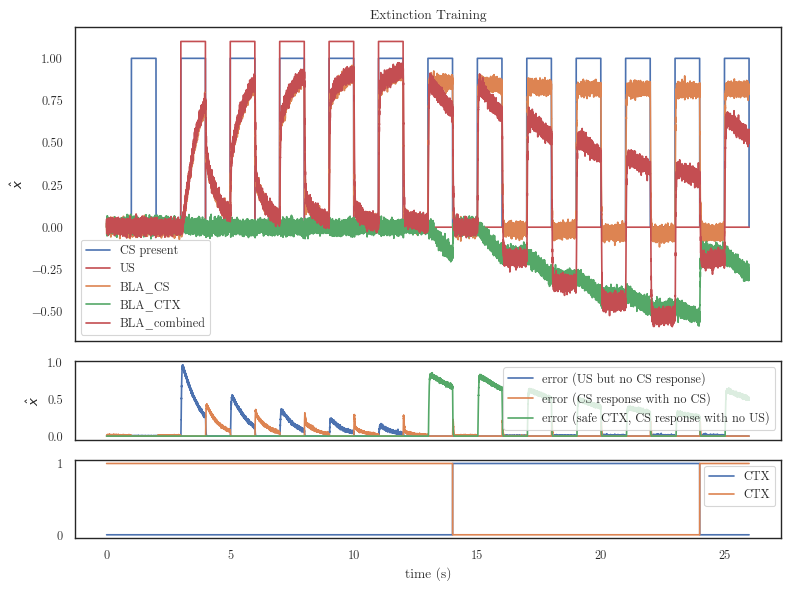

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=((8,6)), gridspec_kw={'height_ratios': [4,1,1]})
axes[0].plot(sim.trange(), np.linalg.norm(sim.data[pCS], ord=2, axis=1), label="CS present")
axes[0].plot(sim.trange(), 1.1*sim.data[pUS], label="US", c='r')
axes[0].plot(sim.trange(), sim.data[pBLA][:,0], label="BLA_CS")
# axes[0].plot(sim.trange(), sim.data[pBLA][:,1], label="BLA_US")
axes[0].plot(sim.trange(), sim.data[pBLA][:,2], label="BLA_CTX")
axes[0].plot(sim.trange(), sim.data[pBLA][:,3], label="BLA_combined")
axes[0].legend()
axes[0].set(ylabel=r"$\hat{x}$", title="Extinction Training")
axes[1].plot(sim.trange(), sim.data[pError_CS], label="error (US but no CS response)")
axes[1].plot(sim.trange(), sim.data[pError_noCS], label="error (CS response with no CS)")
axes[1].plot(sim.trange(), sim.data[pError_CTX], label="error (safe CTX, CS response with no US)")
axes[1].legend()
axes[1].set(ylabel=r"$\hat{x}$")
axes[2].plot(sim.trange(), sim.data[pCTX], label="CTX")
axes[2].set(xlabel="time (s)", yticks=((0,1)))
axes[2].legend()
plt.tight_layout()

### Experiment 3: compare activities over time, looking for fear neurons, extinction neurons, and persistent neurons

In [73]:
A_baseline = sim.data[pSpikes][:int(2/dt)]
A_expression = sim.data[pSpikes][int(2*(nCond+1)/dt): int(2*(nCond+2)/dt)]
dA_cond = np.mean(A_expression - A_baseline, axis=0)
increasing_neurons = np.where(dA_cond>0)[0]
data1 = pd.DataFrame(columns=["neuron", "Activity", "Experiment"])
for n in increasing_neurons:
    data1 = data1.append({"neuron": n, "Activity": np.mean(A_baseline[:,n]), "Experiment": "baseline"}, ignore_index=True)
    data1 = data1.append({"neuron": n, "Activity": np.mean(A_expression[:,n]), "Experiment": "post-conditioning"}, ignore_index=True)

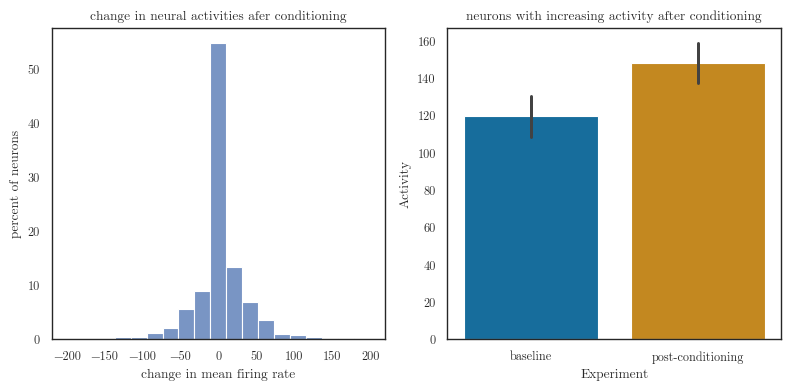

In [89]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=((8,4)))
sns.histplot(dA_cond, ax=axes[0], bins=np.linspace(-200, 200, 20), stat='percent', palette=palette)
axes[0].set(xlabel='change in mean firing rate', ylabel='percent of neurons',
         title='change in neural activities afer conditioning')
sns.barplot(data=data1, x='Experiment', y="Activity", palette=palette)
axes[1].set(title="neurons with increasing activity after conditioning")
plt.tight_layout()

In [128]:
A_post_cond = sim.data[pSpikes][int(2*(nCond+1)/dt): int(2*(nCond+2)/dt)]
A_post_ext = sim.data[pSpikes][-int(2/dt):]
A_thr = 10  # hz
dA_ext = np.mean(A_post_ext - A_post_cond, axis=0)
extinction_neurons = np.where(dA_ext>A_thr)[0]
fear_neurons = np.where(dA_ext<-A_thr)[0]
all_neurons = np.arange(dA_ext.shape[0])
nonpersistent_neurons = np.concatenate((extinction_neurons, fear_neurons))
persistent_neurons = np.setdiff1d(all_neurons, nonpersistent_neurons)

data2 = pd.DataFrame(columns=["neuron", "type", "Activity", "Experiment"])
for n in fear_neurons:
    data2 = data2.append({"neuron": n, "type": "fear", "Activity": np.mean(A_post_cond[:,n]), "Experiment": "post-conditioning"}, ignore_index=True)
    data2 = data2.append({"neuron": n, "type": "fear", "Activity": np.mean(A_post_ext[:,n]), "Experiment": "post-extinction"}, ignore_index=True)
for n in persistent_neurons:
    data2 = data2.append({"neuron": n, "type": "persistent", "Activity": np.mean(A_post_cond[:,n]), "Experiment": "post-conditioning"}, ignore_index=True)
    data2 = data2.append({"neuron": n, "type": "persistent", "Activity": np.mean(A_post_ext[:,n]), "Experiment": "post-extinction"}, ignore_index=True)
for n in extinction_neurons:
    data2 = data2.append({"neuron": n, "type": "extinction", "Activity": np.mean(A_post_cond[:,n]), "Experiment": "post-conditioning"}, ignore_index=True)
    data2 = data2.append({"neuron": n, "type": "extinction", "Activity": np.mean(A_post_ext[:,n]), "Experiment": "post-extinction"}, ignore_index=True)

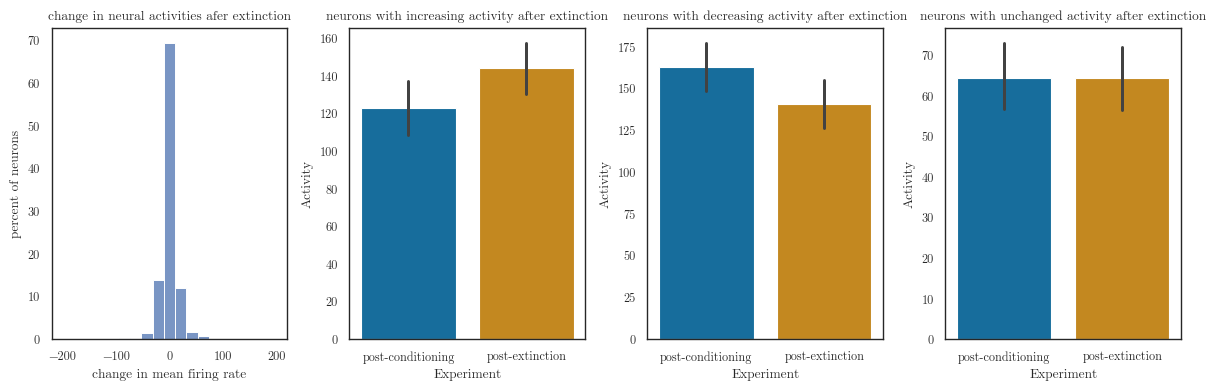

In [135]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=((12,4)))
sns.histplot(dA_ext, bins=np.linspace(-200, 200, 20), stat='percent', palette=palette, ax=axes[0])
axes[0].set(xlabel='change in mean firing rate', ylabel='percent of neurons',
         title='change in neural activities afer extinction')
sns.barplot(data=data2.query("type=='extinction'"), x='Experiment', y="Activity", palette=palette, ax=axes[1])
axes[1].set(title="neurons with increasing activity after extinction")
sns.barplot(data=data2.query("type=='fear'"), x='Experiment', y="Activity", palette=palette, ax=axes[2])
axes[2].set(title="neurons with decreasing activity after extinction")
sns.barplot(data=data2.query("type=='persistent'"), x='Experiment', y="Activity", palette=palette, ax=axes[3])
axes[3].set(title="neurons with unchanged activity after extinction")
plt.tight_layout()